In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import torch

from policy import DPAgent
from simulation import Simulator, CustomerGenerator
from hazard_models import ExponentialHazard
from utility_learner import ProjectedVolumeLearner, diam
from degradation_learner import DegradationLearner

from utils import unit_ball_rejection_sample, correct_signs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import logging
logging.basicConfig(level=logging.INFO)

np.set_printoptions(suppress=True)

In [2]:
# --- 2. Define Sampling Functions ---
# def context_sampler() -> np.ndarray:
#     """Samples a customer's context vector from a uniform distribution."""
#     return np.random.uniform(low=0.0, high=1.0, size=D)

def context_sampler() -> np.ndarray:
    """Samples a customer's context vector uniformly from the unit ball."""
    return np.abs(unit_ball_rejection_sample(D))

def rental_sampler() -> float:
    """Samples a customer's desired rental duration from an exponential distribution."""
    return np.random.exponential(scale=10.0)

def interarrival_sampler() -> float:
    """Samples the time until the next customer arrives."""
    return np.random.exponential(scale=5.0)

In [3]:
# --- 1. Simulation Configuration ---
D = 4                                  # Dimension of context vectors
LAMBDA_VAL = 0.001                     # Baseline hazard constant
NUM_CUSTOMERS = 20000                   # Total number of customers to simulate, i.e. T

# Set a random seed for reproducibility
np.random.seed(41)

# Ground truth vectors
THETA_TRUE = np.array([0.5, 0.2, 0.1, 0.3])#$, 0.4])    # For degradation
UTILITY_TRUE = context_sampler()  # For customer's willingness to pay

# --- Machine's Pricing Vector 'r' ---
# This is a fallback pricing vector, when we don't feed u_hat to calculate_price
PRICING_R = np.zeros(D)

In [7]:
usage_exp_hazard_model = ExponentialHazard(lambda_val=LAMBDA_VAL)
# spontaneous_exp_hazard_model = None # ExponentialHazard(lambda_val=0.01)

customer_gen = CustomerGenerator(
    d=D,
    context_sampler=context_sampler,
    rental_sampler=rental_sampler,
    interarrival_sampler=interarrival_sampler
)

centroid_params = {
    # 'num_samples': 2000,
    # 'thin': None,
    # 'burn_in': 500 * D ** 2,
    # 'tol': 1e-4,
    # 'rho_target': 0.01
}

termination_rule = lambda diameter: diameter < 0.0001  # Example custom termination rule

projected_volume_learner = ProjectedVolumeLearner(
    T=NUM_CUSTOMERS, 
    d=D, 
    centroid_params=centroid_params,
    incentive_constant=1.1,
    termination_rule=termination_rule,
)

mdp_params = {
    'replacement_cost': 1.5,   # Cost to replace the machine
    'failure_cost': 0.75,      # Additional penalty for in-service failure
    'holding_cost_rate': 0.02,   # Cost per unit of idle time
    'gamma': 0.99,             # Discount factor
    'learning_rate': 1e-3,      # Learning rate for the Adam optimizer
    'target_update_freq': 10    # How often to update the target network (in iterations)
}

training_hyperparams = {
    'num_iterations': 50, # Number of training iterations per policy update
    'dataset_size': 50000,      # Number of transitions to generate for the offline dataset
    'batch_size': 2048           # Batch size for training
}

policy_params = {
    'type': 'softmax',
    'tau': 1.0,
    'epsilon': 0.1,
}

# Instantiate the Simulator with the new parameters
simulator = Simulator(
    d=D,
    T=NUM_CUSTOMERS,
    
    theta_true=THETA_TRUE,
    utility_true=UTILITY_TRUE,
    pricing_r=PRICING_R,
    
    usage_hazard_model=usage_exp_hazard_model,
    customer_generator=customer_gen,
    projected_volume_learner=projected_volume_learner,  # Use default ProjectedVolumeLearner
    
    mdp_params=mdp_params,
    training_hyperparams=training_hyperparams,
    policy_params=policy_params,
    policy_update_threshold=5,
    time_normalize=True,
)

In [10]:
UTILITY_TRUE

array([0.12450167, 0.10850869, 0.43930126, 0.71356037])

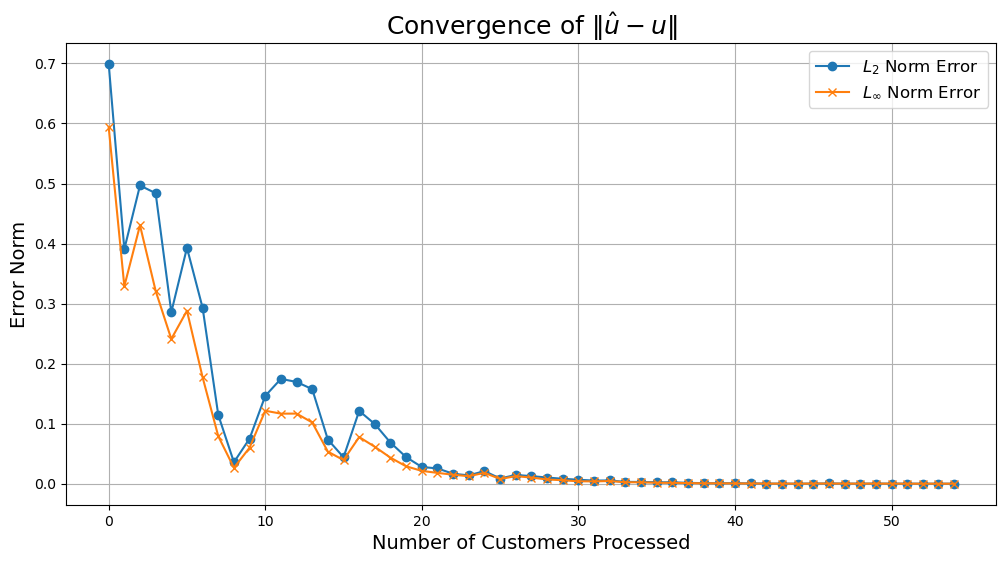

In [22]:
simulator.utility_updates

# plot L2, and L-inf norms of utility updates
L2_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE) for update in simulator.utility_updates]
Linf_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE, ord=np.inf) for update in simulator.utility_updates]

plt.figure(figsize=(12, 6))
plt.plot(L2_errors, label='$L_2$ Norm Error', marker='o')
plt.plot(Linf_errors, label='$L_\infty$ Norm Error', marker='x')
# plt.yscale('log')
plt.xlabel('Number of Customers Processed', fontsize=14)
plt.ylabel('Error Norm', fontsize=14)

plt.title('Convergence of $\|\hat u - u\|$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('figures/utility_convergence.pdf')
plt.show()

In [8]:
# simulator.projected_volume_learner.is_terminated = True
simulation_data = simulator.run(num_customers=NUM_CUSTOMERS)
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

INFO:root:Starting simulation for 20000 customers...
  0%|          | 46/20000 [18:14<210:55:14, 38.05s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 47: Diameter: 0.0005
  0%|          | 49/20000 [20:16<219:48:10, 39.66s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 50: Diameter: 0.0001
  0%|          | 51/20000 [21:38<223:02:15, 40.25s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 52: Diameter: 0.0002
  0%|          | 52/20000 [22:20<225:50:51, 40.76s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 53: Diameter: 0.0002
  0%|          | 53/20000 [23:03<230:37:33, 41.62s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 54: Diameter: 0.0002
  0%|          | 54/20000 [23:47<234:41:12, 42.36s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 55: Diameter: 0.0001
  0%|      

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.09861D+00    |proj g|=  7.51808D-01

At iterate    1    f=  5.26910D-01    |proj g|=  2.67514D-01

At iterate    2    f=  3.05592D-01    |proj g|=  4.82350D-02

At iterate    3    f=  3.00394D-01    |proj g|=  3.39379D-02

At iterate    4    f=  2.94887D-01    |proj g|=  3.42631D-03

At iterate    5    f=  2.94825D-01    |proj g|=  2.75754D-04

At iterate    6    f=  2.94824D-01    |proj g|=  2.46829D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

  0%|          | 55/20000 [24:41<149:14:27, 26.94s/it]


KeyboardInterrupt: 

## Training policy under perfect information

In [25]:
class PerfectDegradationLearner:
    def __init__(self, d, theta_true, hazard_model):
        self.d = d
        self.theta_true = theta_true
        self.hazard_model = hazard_model  # Placeholder, not used
        
    def get_theta(self):
        return self.theta_true
    
    def cum_baseline(self, t):
        return self.hazard_model.Lambda_0(t)
    
    def inverse_cum_baseline(self, u):
        return self.hazard_model.Lambda_0_inverse(u)
    
perfect_degradation_learner = PerfectDegradationLearner(
    d=D, 
    theta_true=THETA_TRUE,
    hazard_model=usage_exp_hazard_model,
)

perfect_dpagent = DPAgent(
    d=D,
    u_hat=UTILITY_TRUE,
    time_normalize=True,
    degradation_learner=perfect_degradation_learner,
    customer_generator=customer_gen,
    params=mdp_params,
)

# weight = torch.load('weights/perfect_dpagent_q_network.pth', map_location=torch.device('cuda'))
# perfect_dpagent.q_network.load_state_dict(weight)
# perfect_dpagent.q_network.to(perfect_dpagent.device)
# perfect_dpagent.q_network.eval()
perfect_dpagent.train(
    num_iterations=50,
    dataset_size=500000,
    batch_size=1024
)

perfect_policy = perfect_dpagent.get_policy(
    {'type': 'greedy', 'epsilon': 0.1, 'tau': 1.0}
)

Using device: cuda
Generating 500000 experience samples...


100%|██████████| 500000/500000 [00:08<00:00, 59906.04it/s]



Starting FQI training loop...


  0%|          | 0/50 [00:59<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
num_repeat = 10
histories = []

for _ in range(num_repeat):
    history = simulator.run_full_exploit(10000, policy)
    history = pd.DataFrame(history)
    
    history['net_profit'] = history['profit'] + history['loss']
    # calculate cumulative profit and loss
    history['cumulative_net_profit'] = history['net_profit'].cumsum()
    histories.append(history)


In [ ]:
ax = plt.figure(figsize=(10,6))

# plot cumulative profit and loss over time
plt.plot(history['calendar_time'], history['cumulative_net_profit'], label='Cumulative Net Profit')
plt.xlabel('Calendar Time')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Over Time')
plt.legend()
plt.grid()
plt.show()

### Debugging: Look at experience dataset

In [ ]:
from policy import DPAgent

print(simulator.projected_volume_learner.get_estimate())
print(UTILITY_TRUE)

dp_agent = DPAgent(
    d=simulator.d,
    u_hat=simulator.projected_volume_learner.get_estimate(),
    time_normalize=simulator.time_normalize,
    degradation_learner=simulator.degradation_learner,
    customer_generator=simulator.customer_generator,
    params=simulator.mdp_params
)

dataset = dp_agent.experience_generator.generate(500)

for data in dataset:
    state, action, reward, next_state = data
    print("State:", state.round(3))
    print("Action:", dp_agent.experience_generator.ACTION_MAP[action])
    print("Reward:", reward)
    print("Next State:", next_state.round(3))
    print("-----")
    print()

In [ ]:
degradation_learner = DegradationLearner(d=D, initial_theta=np.zeros(D))
degradation_df = pd.DataFrame(simulator.degradation_history)
degradation_learner.fit(degradation_df)
degradation_learner.get_theta()

Testing Policy

In [ ]:
i = 50

X_i = df.loc[i, 'sum_of_contexts_after']
I_i = 3 # df.loc[i, '']
x_i = df.loc[i+1, 'customer_context']
T_i = df.loc[i+1, 'rental_duration']

arrival_state = np.concatenate([
    X_i,
    x_i,
    [T_i, I_i, 0.0]
])
action_arrival = optimal_policy(arrival_state)
action_map = {0: 'Give Max Acceptable Price', 1: 'Shutdown'}
print(f"Sample Arrival State. Optimal Action: {action_map[action_arrival]}")


In [ ]:
# Test Case 2: Departure State
departure_state = np.concatenate([
    X_i+x_i*10, 
    np.zeros(D), 
    [0.0, I_i, 1.0]
])
action_departure = optimal_policy(departure_state)
action_map = {2: 'Replace Machine', 3: 'Do Not Replace'}
print(f"Sample Departure State. Optimal Action: {action_map[action_departure]}")
